<a href="https://colab.research.google.com/github/sharmin133/Rice-Leaf/blob/main/Grad_CAM%2B%2B_with_MobileNetV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
from IPython.display import Image, display
import matplotlib.cm as cm
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [ ]:
image_dir = Path('/content/drive/MyDrive/Final Thesis/preprocessing/resize dataset')


filepaths = list(image_dir.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')


image_df = pd.concat([filepaths, labels], axis=1)

image_df = image_df[image_df['Label'].apply(lambda x: x[-2:] != 'GT')]

In [ ]:

image_df = image_df.sample(frac=1).reset_index(drop = True)
image_df.head(5)

,Filepath,Label
0,/content/drive/MyDrive/Final Thesis/preprocess...,Brownspot
1,/content/drive/MyDrive/Final Thesis/preprocess...,Bacterialblight
2,/content/drive/MyDrive/Final Thesis/preprocess...,_Healthy
3,/content/drive/MyDrive/Final Thesis/preprocess...,_Healthy
4,/content/drive/MyDrive/Final Thesis/preprocess...,_Healthy


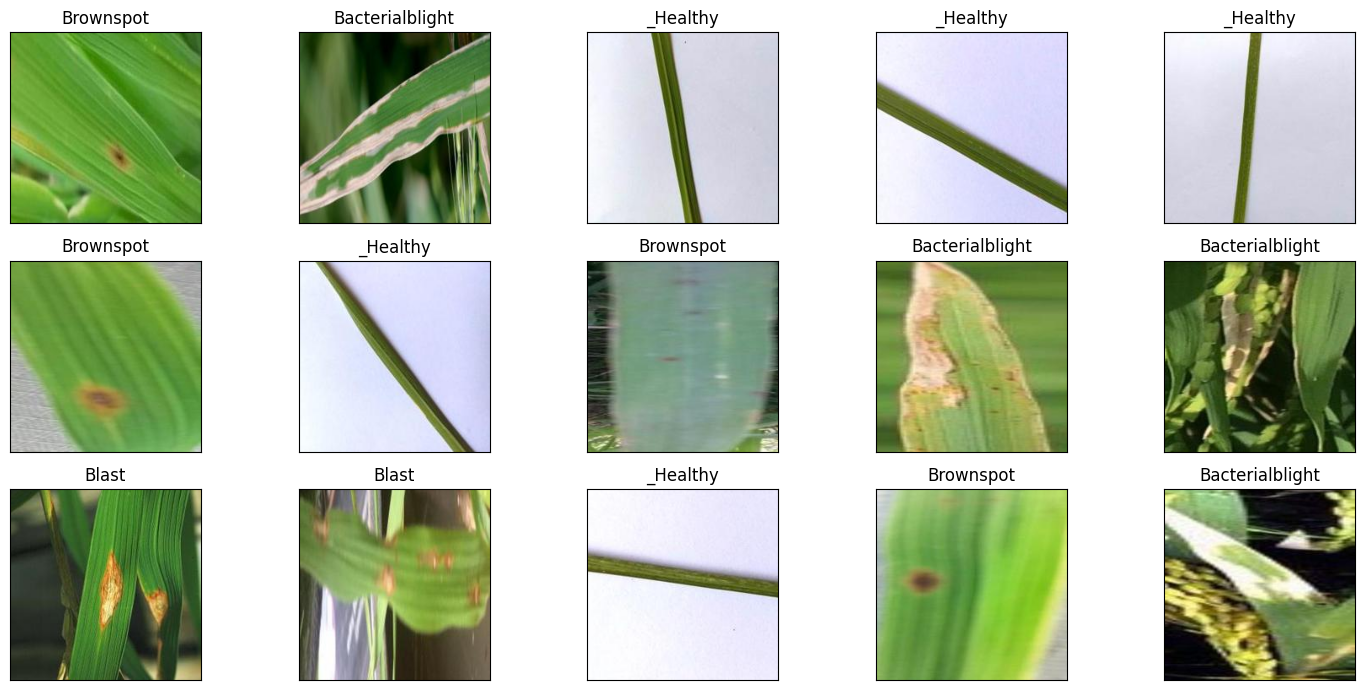

In [ ]:

fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[i]))
    ax.set_title(image_df.Label[i])
plt.tight_layout()
plt.show()

In [ ]:

train_df, test_df = train_test_split(image_df, train_size=0.8, shuffle=True, random_state=1)

In [ ]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.1
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [ ]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(96,96),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(96,96),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(96,96),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)


Found 4145 validated image filenames belonging to 5 classes.
Found 460 validated image filenames belonging to 5 classes.
Found 1152 validated image filenames belonging to 5 classes.


In [ ]:

pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(96,96, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:

pretrained_model.summary()

Model: "mobilenetv2_1.00_96"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 96, 96, 3)]          0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 48, 48, 32)           864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 48, 48, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 48, 48, 32)           0         ['bn_Conv1[0

In [ ]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(pretrained_model.output)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)


x = tf.keras.layers.Dropout(0.5)(x)

outputs = tf.keras.layers.Dense(5, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=20,
    verbose=1,
)

Epoch 1/20
130/130 [==============================] - 1298s 10s/step - loss: 2.9748 - accuracy: 0.7199 - val_loss: 1.7820 - val_accuracy: 0.9239
Epoch 2/20
130/130 [==============================] - 41s 312ms/step - loss: 1.5094 - accuracy: 0.9028 - val_loss: 1.0711 - val_accuracy: 0.9587
Epoch 3/20
130/130 [==============================] - 40s 305ms/step - loss: 0.9413 - accuracy: 0.9489 - val_loss: 0.6686 - val_accuracy: 0.9913
Epoch 4/20
130/130 [==============================] - 42s 324ms/step - loss: 0.6459 - accuracy: 0.9648 - val_loss: 0.4842 - val_accuracy: 0.9870
Epoch 5/20
130/130 [==============================] - 48s 366ms/step - loss: 0.4900 - accuracy: 0.9665 - val_loss: 0.3932 - val_accuracy: 0.9848
Epoch 6/20
130/130 [==============================] - 40s 310ms/step - loss: 0.3995 - accuracy: 0.9785 - val_loss: 0.3021 - val_accuracy: 0.9913
Epoch 7/20
130/130 [==============================] - 42s 319ms/step - loss: 0.3510 - accuracy: 0.9696 - val_loss: 0.2622 - val_ac

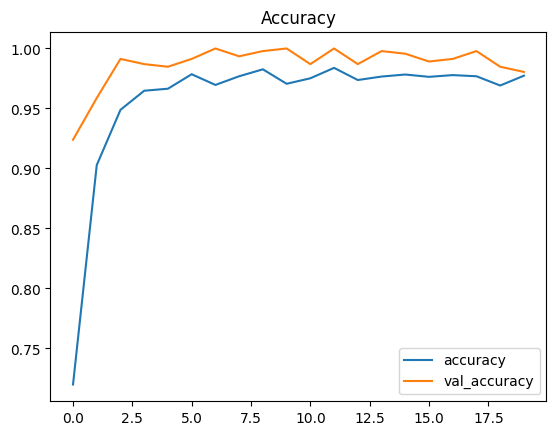

In [ ]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

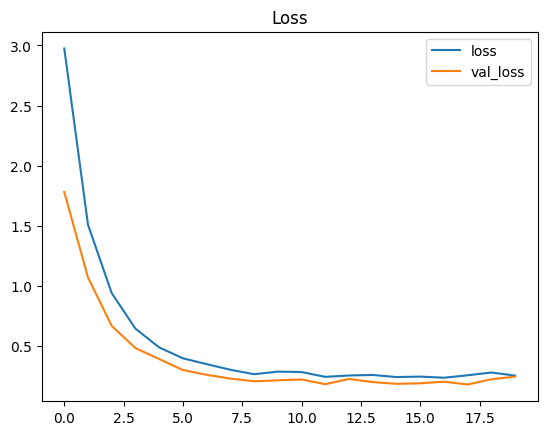

In [ ]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [ ]:

pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

print(f'The first 5 predictions: {pred[:5]}')

36/36 [==============================] - 295s 8s/step
The first 5 predictions: ['Bacterialblight', 'Bacterialblight', 'Tungro', 'Brownspot', '_Healthy']


In [ ]:
from sklearn.metrics import classification_report
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

                 precision    recall  f1-score   support

Bacterialblight       1.00      0.95      0.97       259
          Blast       0.93      1.00      0.96       176
      Brownspot       0.99      0.99      0.99       300
         Tungro       1.00      1.00      1.00        98
       _Healthy       1.00      1.00      1.00       319

       accuracy                           0.99      1152
      macro avg       0.98      0.99      0.98      1152
   weighted avg       0.99      0.99      0.99      1152



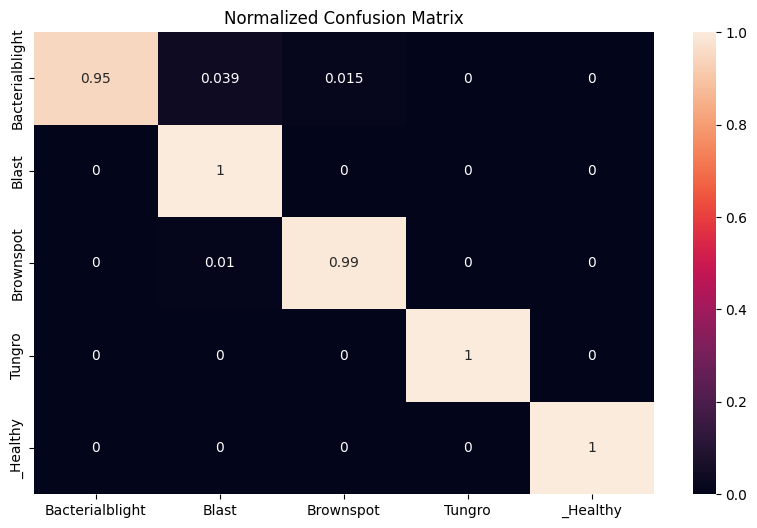

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,6))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Normalized Confusion Matrix')
plt.show()

In [ ]:

last_conv_layer_name = "Conv1"
img_size = (96,96)

In [ ]:

def make_gradcam_plus_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)

    gate_f = tf.cast(last_conv_layer_output > 0, 'float32')
    gate_r = tf.cast(grads > 0, 'float32')

    guided_grads = gate_f * gate_r * grads

    weights = tf.reduce_mean(guided_grads, axis=(0, 1))
    cam = tf.reduce_sum(tf.multiply(weights, last_conv_layer_output), axis=-1)
    cam = np.maximum(cam, 0)
    heatmap = cam / np.max(cam)

    return heatmap

In [ ]:
def save_and_display_gradcam_plus(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    img = tf.keras.preprocessing.image.load_img(img_path)
    img = tf.keras.preprocessing.image.img_to_array(img)

    heatmap = np.uint8(224 * heatmap)

    jet = cm.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

    superimposed_img.save(cam_path)

    return cam_path

<ipython-input-23-cbdb5f514e89>:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


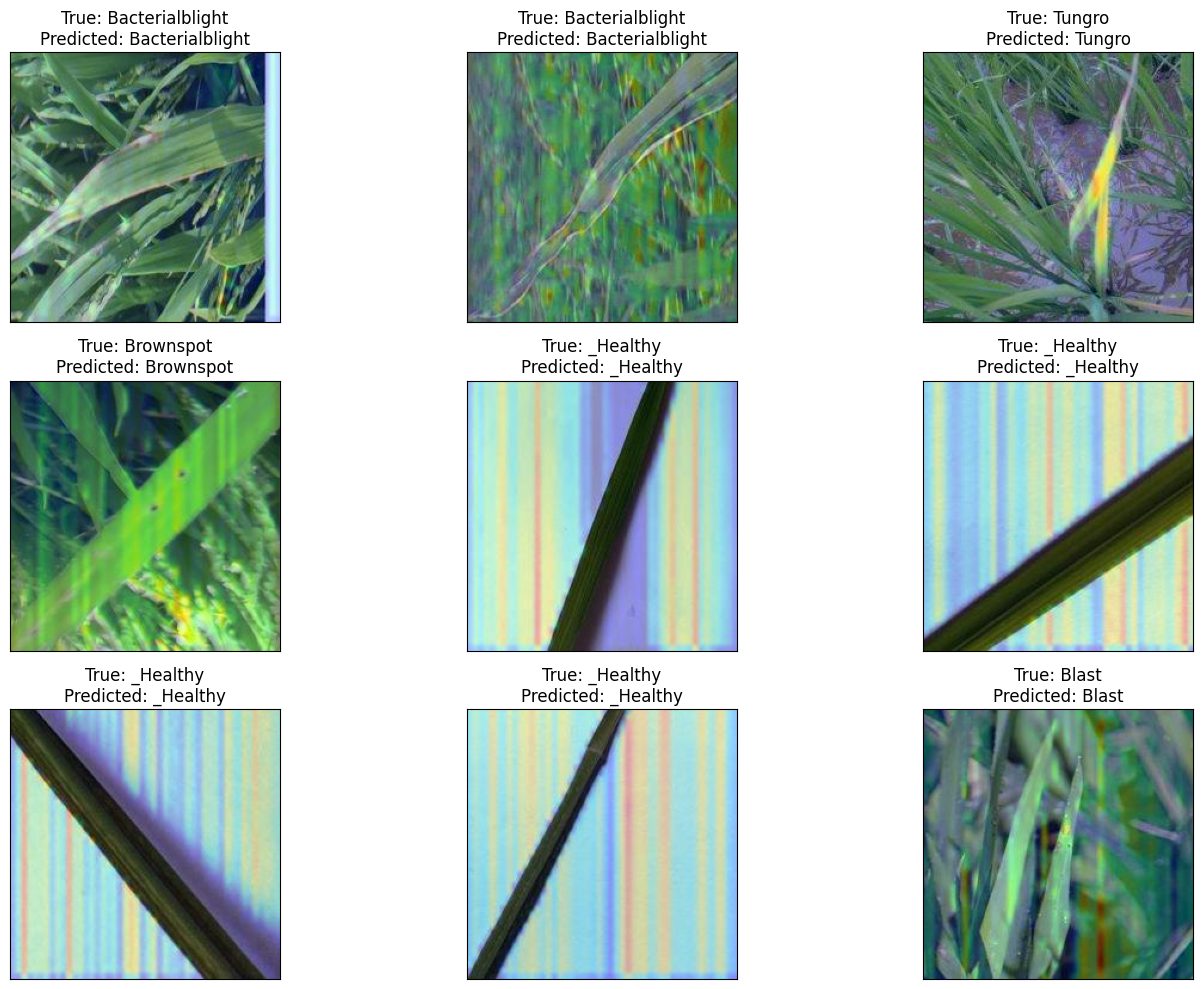

In [ ]:

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    img_path = test_df.Filepath.iloc[i]
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=img_size)
    img_array = tf.keras.preprocessing.image.img_to_array(img)


    img_array = np.expand_dims(img_array, axis=0)

    img_array = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)

    heatmap = make_gradcam_plus_heatmap(img_array, model, last_conv_layer_name)
    heatmap = heatmap[0, :, :]
    cam_path = save_and_display_gradcam_plus(img_path, heatmap)
    ax.imshow(plt.imread(cam_path))
    ax.set_title(f"True: {test_df.Label.iloc[i]}\nPredicted: {pred[i]}")

plt.tight_layout()
plt.show()